This notebook is intended to test the mavenn functionality which enables the computation of parameter uncertainties via inference on simulated data

In [1]:
# Standard imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import time
import tensorflow as tf
%matplotlib inline

#Load mavenn and check path
import mavenn

In [2]:
# Load example data
data_df = mavenn.load_example_dataset('mpsa')
trainval_df, test_df = mavenn.split_dataset(data_df)
print(f'training + validation N: {len(trainval_df):,}')
trainval_df.head(10)

Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training + validation N: 24,405


,validation,tot_ct,ex_ct,y,x
0,False,28,2,0.023406,GGAGUGAUG
1,False,193,15,-0.074999,UUCGCGCCA
2,False,27,0,-0.438475,UAAGCUUUU
3,False,130,2,-0.631467,AUGGUCGGG
4,False,552,19,-0.433012,AGGGCAGGA
5,False,216,6,-0.482679,GGUGUCUGU
6,True,88,4,-0.241737,CAGGCAAAC
7,False,14,0,-0.167408,CAUGCAGCU
8,False,170,14,-0.048222,CAAGUCACU
9,False,242,13,-0.230795,UCCGCGCUA


In [3]:
# Get sequence length
L = len(trainval_df['x'][0])

# Define model
model = mavenn.Model(L=L,
                     alphabet='rna',
                     gpmap_type='pairwise', 
                     regression_type='GE',
                     ge_noise_model_type='SkewedT',
                     ge_heteroskedasticity_order=2)

In [4]:
# Set training data
model.set_data(x=trainval_df['x'],
               y=trainval_df['y'],
               validation_flags=trainval_df['validation'],
               shuffle=True)

N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.213 sec.


In [5]:
# Fit model to data
model.fit(learning_rate=.001,
          epochs=300,
          batch_size=200,
          early_stopping=True,
          early_stopping_patience=30,
          try_tqdm = True,
          linear_initialization=True,
          verbose=False)

0epoch [00:00, ?epoch/s]

Training time: 14.5 seconds


In [6]:
model.fit_args

{'epochs': 300,
 'learning_rate': 0.001,
 'validation_split': 0.2,
 'verbose': False,
 'early_stopping': True,
 'early_stopping_patience': 30,
 'batch_size': 200,
 'linear_initialization': True,
 'freeze_theta': False,
 'try_tqdm': True,
 'optimizer': 'Adam',
 'optimizer_kwargs': {'learning_rate': 0.001},
 'fit_kwargs': {}}

In [7]:
# # Save model
model.save('mpsa_ge_additive')

Model saved to these files:
	mpsa_ge_additive.pickle
	mpsa_ge_additive.h5


In [8]:
# Load model
model = mavenn.load('mpsa_ge_additive')

Model loaded from these files:
	mpsa_ge_additive.pickle
	mpsa_ge_additive.h5


In [9]:
model.fit_args

{'epochs': 300,
 'learning_rate': 0.001,
 'validation_split': 0.2,
 'verbose': False,
 'early_stopping': True,
 'early_stopping_patience': 30,
 'batch_size': 200,
 'linear_initialization': True,
 'freeze_theta': False,
 'try_tqdm': True,
 'optimizer': 'Adam',
 'optimizer_kwargs': {'learning_rate': 0.001},
 'fit_kwargs': {}}

In [10]:
# Get x and y
x_test = test_df['x'].values
y_test = test_df['y'].values

On test data:
I_var_test: 0.323 +- 0.025 bits
I_pred_test: 0.362 +- 0.018 bits


Text(0.5, 1.0, 'training hisotry')

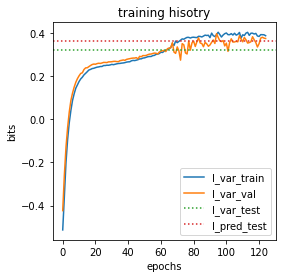

In [11]:
# Show training history
print('On test data:')

# Compute variational information
I_var, dI_var =  model.I_variational(x=x_test, y=y_test)
print(f'I_var_test: {I_var:.3f} +- {dI_var:.3f} bits') 

# Compute predictive information
I_pred, dI_pred = model.I_predictive(x=x_test, y=y_test)
print(f'I_pred_test: {I_pred:.3f} +- {dI_pred:.3f} bits')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.axhline(I_var, color='C2', linestyle=':', label='I_var_test')
ax.axhline(I_pred, color='C3', linestyle=':', label='I_pred_test')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')
#ax.set_ylim([0, I_pred*1.2]);

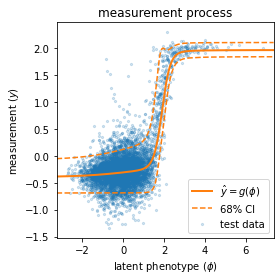

In [12]:
# Predict latent phentoype values (phi) on test data
phi_test = model.x_to_phi(x_test)

# Predict measurement values (yhat) on test data
yhat_test = model.x_to_yhat(x_test)

# Set phi lims and create grid in phi space
phi_lim = [min(phi_test)-.5, max(phi_test)+.5]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Compute yhat each phi gridpoint
yhat_grid = model.phi_to_yhat(phi_grid)

# Compute 90% CI for each yhat
q = [0.05, 0.95] #[0.16, 0.84]
yqs_grid = model.yhat_to_yq(yhat_grid, q=q)

# Create figure
fig, ax = plt.subplots(1, 1, figsize=[4, 4])

# Illustrate measurement process with GE curve
ax.scatter(phi_test, y_test, color='C0', s=5, alpha=.2, label='test data')
ax.plot(phi_grid, yhat_grid, linewidth=2, color='C1',
        label='$\hat{y} = g(\phi)$')
ax.plot(phi_grid, yqs_grid[:, 0], linestyle='--', color='C1', label='68% CI')
ax.plot(phi_grid, yqs_grid[:, 1], linestyle='--', color='C1')
ax.set_xlim(phi_lim)
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_ylabel('measurement ($y$)')
ax.set_title('measurement process')
ax.legend()

# Fix up plot
fig.tight_layout()
plt.show()

In [13]:
model.simulate_dataset(template_df=data_df)

,set,phi,yhat,y,x
0,training,0.775821,-0.265478,-0.010113,GGAGUGAUG
1,test,0.876489,-0.255576,-0.275899,AGUGUGCAA
2,training,-0.424513,-0.324536,-0.436904,UUCGCGCCA
3,training,-0.600959,-0.331015,-0.050174,UAAGCUUUU
4,training,0.778551,-0.265240,-0.120699,AUGGUCGGG
...,...,...,...,...,...
30478,training,-0.064295,-0.310319,-0.323053,CUGGUUGCA
30479,training,-0.839909,-0.339232,-0.133724,CGCGCACAA
30480,test,-1.047738,-0.345815,-0.121129,ACUGCUCAC
30481,training,-1.920521,-0.367339,-0.005915,AUAGUCUAA


In [14]:
#uncertainty_dict = model.compute_parameter_uncertainties(num_simulations=2)
sim_models = model.sample_plausible_models(data_df=data_df,
                                           num_models=20,
                                           initialize_from_fit_model=True,)

Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 0 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.212 sec.


0epoch [00:00, ?epoch/s]

Training time: 4.4 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 1 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.214 sec.


0epoch [00:00, ?epoch/s]

Training time: 5.4 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 2 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.215 sec.


0epoch [00:00, ?epoch/s]

Training time: 4.2 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 3 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.216 sec.


0epoch [00:00, ?epoch/s]

Training time: 7.8 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 4 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.213 sec.


0epoch [00:00, ?epoch/s]

Training time: 5.5 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 5 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.215 sec.


0epoch [00:00, ?epoch/s]

Training time: 6.7 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 6 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.218 sec.


0epoch [00:00, ?epoch/s]

Training time: 5.3 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 7 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.216 sec.


0epoch [00:00, ?epoch/s]

Training time: 5.2 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 8 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.217 sec.


0epoch [00:00, ?epoch/s]

Training time: 4.6 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 9 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.215 sec.


0epoch [00:00, ?epoch/s]

Training time: 5.2 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 10 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.219 sec.


0epoch [00:00, ?epoch/s]

Training time: 4.4 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 11 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.214 sec.


0epoch [00:00, ?epoch/s]

Training time: 5.8 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 12 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.217 sec.


0epoch [00:00, ?epoch/s]

Training time: 5.1 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 13 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.217 sec.


0epoch [00:00, ?epoch/s]

Training time: 4.5 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 14 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.215 sec.


0epoch [00:00, ?epoch/s]

Training time: 5.5 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 15 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.216 sec.


0epoch [00:00, ?epoch/s]

Training time: 4.6 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 16 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.216 sec.


0epoch [00:00, ?epoch/s]

Training time: 6.2 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 17 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.216 sec.


0epoch [00:00, ?epoch/s]

Training time: 5.0 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 18 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.216 sec.


0epoch [00:00, ?epoch/s]

Training time: 5.2 seconds
Training set   :   18,469 observations (  60.59%)
Validation set :    5,936 observations (  19.47%)
Test set       :    6,078 observations (  19.94%)
-------------------------------------------------
Total dataset  :   30,483 observations ( 100.00%)

training model 19 ...
N = 24,405 observations set as training data.
Using 24.3% for validation.
Data shuffled.
Time to set data: 0.217 sec.


0epoch [00:00, ?epoch/s]

Training time: 5.4 seconds


In [15]:
sim_models

In [16]:
L = model.L
C = model.C
K = len(sim_models)

L*(C)

36

In [17]:
# Compute additive parameter uncertainties 
sim_theta_lck = np.zeros([L,C,K])
for k, sim_model in enumerate(sim_models):
    sim_theta_lck[:,:,k] = sim_model.get_theta()['theta_lc']
    
theta_lc = sim_model.get_theta()['theta_lc']
print(theta_lc.shape)

theta_lc_df = pd.DataFrame()
theta_lc_df['true'] = theta_lc.ravel()
theta_lc_df['mean'] = sim_theta_lck.mean(axis=2).ravel()
theta_lc_df['std'] = sim_theta_lck.std(axis=2).ravel()
theta_lc_df = theta_lc_df.dropna().sort_values(by='true')
theta_lc_df = theta_lc_df[~np.isclose(theta_lc_df['true'],0)].reset_index(drop=True)

theta_lc_df

(9, 4)


,true,mean,std
0,-0.472896,-0.496482,0.028030
1,-0.444595,-0.449934,0.019768
2,-0.413034,-0.412944,0.020125
3,-0.397992,-0.378135,0.051755
4,-0.383792,-0.355717,0.051492
5,-0.345341,-0.444104,0.060430
6,-0.234120,-0.212741,0.057012
7,-0.232937,-0.323704,0.050094
8,-0.221480,-0.225808,0.005891
9,-0.185930,-0.180715,0.004110


In [18]:
# Compute parameter uncertainties
sim_theta_lclck = np.zeros([L,C,L,C,K])
for k, sim_model in enumerate(sim_models):
    sim_theta_lclck[:,:,:,:,k] = sim_model.get_theta()['theta_lclc']
    
theta_lclc = sim_model.get_theta()['theta_lclc']
print(theta_lclc.shape)

theta_lclc_df = pd.DataFrame()
theta_lclc_df['true'] = theta_lclc.ravel()
theta_lclc_df['mean'] = sim_theta_lclck.mean(axis=-1).ravel()
theta_lclc_df['std'] = sim_theta_lclck.std(axis=-1).ravel()
theta_lclc_df = theta_lclc_df.dropna().sort_values(by='true')
theta_lclc_df = theta_lclc_df[~np.isclose(theta_lclc_df['true'],0)].reset_index(drop=True)
theta_lclc_df

(9, 4, 9, 4)


,true,mean,std
0,-0.880217,-0.831176,0.043176
1,-0.765995,-0.635977,0.047558
2,-0.729372,-0.711101,0.031249
3,-0.697302,-0.706110,0.027125
4,-0.687983,-0.686030,0.026900
...,...,...,...
387,0.599263,0.570069,0.036427
388,0.638254,0.616059,0.035182
389,0.804116,0.770841,0.027157
390,0.826860,0.857511,0.029757


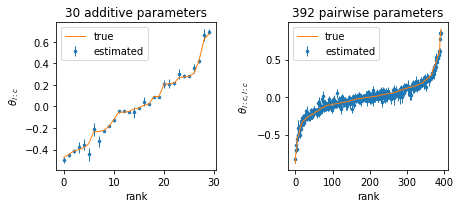

In [27]:
fig, axs = plt.subplots(1,2,figsize=[6.5,3])

ax = axs[0]
ax.errorbar(x=theta_lc_df.index,
            y=theta_lc_df['mean'],
            yerr=theta_lc_df['std'],
            label='estimated',
            linewidth=0,
            elinewidth=1,
            marker='.',
            markersize=5)
ax.plot(theta_lc_df.index,
        theta_lc_df['true'].values,
        label='true',
        linewidth=1,
        zorder=10)
#ax.set_xticks([])
ax.legend()
ax.set_title(f'{len(theta_lc_df)} additive parameters')
ax.set_xlabel('rank')
ax.set_ylabel(r'$\theta_{l:c}$')

ax = axs[1]
ax.errorbar(x=theta_lclc_df.index,
            y=theta_lclc_df['mean'],
            yerr=theta_lclc_df['std'],
            label='estimated',
            linewidth=0,
            elinewidth=1,
            marker='.',
            markersize=5)
ax.plot(theta_lclc_df.index,
        theta_lclc_df['true'].values,
        label='true',
        linewidth=1,
        zorder=10)
#ax.set_xticks([])
ax.legend()
ax.set_title(f'{len(theta_lclc_df)} pairwise parameters')
ax.set_xlabel('rank')
ax.set_ylabel(r'$\theta_{l:c,l:c}$')

fig.tight_layout()
fig.savefig('21.12.26_mpsa_theta_uncertainties.png', dpi=300)